#### This notebook contains code to develop the clustering model. A diagrammatic representation of the model development and data analysis approach is shown below:

<img alt="Diagrammatic representation of the analysis approach" src="static/QuantAnalysisApproach.png" title = "Model Dev and Analysis Approach"/>

#### <br> The main function when executed will 
- read .csv data in the <strong><em>data </em> </strong> folder 
- create <strong><em>clusterer.pkl</em> </strong> file in the <strong><em>models</em> </strong> folder
- create a <strong><em>us_community_df.csv</em> </strong> dataset in the <strong><em>data </em> </strong> folder 

#### <br>  The <strong> <em> Analyze Results </em> </strong>  part is covered in a separate notebook - <em> AnalyzeResults.ipynb </em>

#### <br> Packages used:
|No.|Package Name|Version #|
|---|------------|---------|
|1|numpy|1.17.0|
|2|pandas|1.1.3|
|3| matplotlib|3.3.4 |
|4| scikitlearn|0.23.2 |
|5| yellowbrick|1.2|
|6| category_encoders|2.2.2| 
|7| pickle|0.7.5 |

#### <br> Metric used for clustering model performance evaluation : Silhouette score 

#### <br> Optimal # of clusters using the elbow method : 8
<img alt="Silhouette score elbow for K Means clusetring" src="static/SilhouetteScoreElbowforKMeansClustering" title = "Silhouette Score Elbow Plot"/>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import plotly.express as px

%matplotlib inline


In [2]:
#load data
def load_data(survey_results_public_filepath,survey_results_schema_filepath):
    '''
    INPUT
        survey_results_public_filepath - Full filepath of survey results responses, incl .csv filename
        survey_results_schema_filepath - Full filepath of survey results schema, incl .csv filename
    OUTPUT
        df - Dataframe containing survey results responses read from corresponding .csv filename
        df2 - Dataframe containing survey results schema read from corresponding .csv filename
    '''
    import pandas as pd
    df = pd.read_csv(survey_results_public_filepath)
    df2 = pd.read_csv(survey_results_schema_filepath)
    return df, df2

def get_unique_list_of_values(input_df,col,delimiter=";"):
    '''
    INPUT
        input_df -  Input data frame containing the column which contains multiple categories separated by ";" delimiter
        colname  -  Column name which is to be used for computation of standard deviation value
        delimiter - Delimiter separating the various values; default value is ';' 
    OUTPUT 
        input_df -  Updated data frame containing engineering features
    '''
    col_series = input_df[col]
    col_series_new = col_series.dropna()
    i=0
    for s in col_series_new:
        col_series_new_list = s.split(delimiter)
        if i==0:
            consol_list = col_series_new_list
        else:
            for j in col_series_new_list:
                consol_list.insert(len(consol_list), j)
            #consol_list = consol_list.extend(devtype_new_list)
        i += 1
    list_of_unique_values = list(set(consol_list))
    print ("List of unique values for ",col," :\n" , list_of_unique_values)
    print ("# of unique values for ",col," :" , len(list_of_unique_values))
    
    return list_of_unique_values

def create_cat_cols_for_multvalcols(source_col,source_value_list,cat_col_list,input_df,colname_prefix,others_categ_list=''):
    '''
    INPUT
        source col - source column from which category columns to be created
        source_value_list  - list containing values to be searched in the source column
        cat_col_list       - list containing category column names to be created
        colname_prefix     - Prefix for column name to be created for rows with missing values
        others_categ_list  - List of categories that need to be cmbined in "Others" category
        input_df                 - source df
    OUTPUT
        input_df           - Updated source df containing category columns created as per columns listed in cat_col_list
    '''
    missing_value_colname = colname_prefix + "NotSpecified"
    input_df [missing_value_colname] = np.where(input_df[source_col].isnull(),1,0)

    i=0
    for source_value in source_value_list:
        cat_col = cat_col_list[i]
        #print("cat col = ",cat_col,"source col = ",source_col)
        input_df [cat_col] = np.where(input_df[source_col].str.contains(source_value),1,0)
        i += 1
    
    #Create a single category - Others for other categories which are not separately created
    if others_categ_list != '':
        others_categ_colname = colname_prefix + "Others"
        for others_categ in others_categ_list:
            input_df [others_categ_colname] = np.where(df[source_col].str.contains(others_categ),1,0)
    return input_df

#Create a function to create numeric fields containing mean of ConvertedComp for each of the categorical values
def create_num_feats_for_catcols(input_df,colname):
    '''
    INPUT
        input_df - Input data frame containing the categorical column
        colname  - Column name which is to be used for computation of standard deviation value; in our case ConvertedComp
    OUTPUT 
        output_df - Updated data frame containing engineered features
    '''
    from category_encoders import TargetEncoder

    #Find list of category columns (engineered features with prefix = Ef_Cat)
    catcol_list = [col for col in input_df.columns if 'Ef_Cat_' in col]
    y = input_df [colname] #This is the column which will be used for target encoding
    X = input_df [catcol_list]
    
    targ_enc = TargetEncoder(cols=catcol_list, smoothing=8, min_samples_leaf=5).fit(X, y)
    X_te = targ_enc.transform(X)
    newcol_list = [col.replace('Ef_Cat_', 'Ef_Num_') for col in catcol_list]
    print("Engineered feature list = ",newcol_list)
    X_te.columns = newcol_list
    X_te.columns
    
    output_df = pd.concat([input_df,X_te],axis=1)
    return output_df

def prepare_data_for_modelling(df):
    import numpy as np
    '''
    INPUT
        df - Input dataframe
    OUTPUT 
        us_cluster_ip_df - Output dataframe containing engineered features for modelling
        us_community_df  - Output dataframe containing survey results data for US country i.e. data science community in USD
    '''
    
    us_community_df = df[(df.Country == 'United States')]
    print("US Developer Community Dataframe shape",us_community_df.shape)
    us_community_df = us_community_df[us_community_df.ConvertedComp.notnull() ] #Select observations where Converted Compensation is not null
    print("US Developer Community Dataframe shape after deleting obs with null values in ConvertedComp" \
          , us_community_df.shape)
    
    #Include observations where role attribute i.e. DevType is not null 
    us_community_df = us_community_df[us_community_df.DevType.notnull() ] #Select observations where Converted Compensation is not null
    print("US Developer Community Dataframe shape after deleting obs with null values in DevType" \
          , us_community_df.shape)

    #Get list of unique values for Developer Type
    list_of_unique_roles = get_unique_list_of_values(us_community_df,'DevType')
    
    #Create a categorical variable for each unique role type listed in the DevType attribute for 
    #each observation
    #Create cat columns for specialist roles 
    specialist_roles = ['DevOps specialist','Data scientist or machine learning specialist' \
                        ,'Developer, full-stack']
    specialist_role_type_list = ['Ef_Cat_DT_DevOpsSpecialist','Ef_Cat_DT_DSOrMLSpecialist' \
                                 ,'Ef_Cat_DT_DeveloperFullStack']
    us_community_df = create_cat_cols_for_multvalcols('DevType' \
                     , specialist_roles,specialist_role_type_list,us_community_df,"Ef_Cat_DT_")

    #Create cat columns for manager-exec roles 
    manager_or_exec_roles = ['Product manager','Engineering manager','Senior executive/VP']
    manager_or_exec_role_type_list = ["Ef_Cat_DT_ProductMgr","Ef_Cat_DT_EnggMgr" \
                                      ,'Ef_Cat_DT_SeniorExecOrVP']
    us_community_df = create_cat_cols_for_multvalcols('DevType' \
                      , manager_or_exec_roles,manager_or_exec_role_type_list,us_community_df \
                      , "Ef_Cat_DT_")

    other_ds_roles = ['Data or business analyst','Engineer, data']
    other_ds_role_type_list = ["Ef_Cat_DT_DataOrBA","Ef_Cat_DT_DataEr"]
    us_community_df = create_cat_cols_for_multvalcols('DevType',other_ds_roles \
                     , other_ds_role_type_list,us_community_df,"Ef_Cat_DT_")

    other_roles=['Engineer, site reliability', 'System administrator', 'Database administrator' \
                 , 'Marketing or sales professional', 'Educator', 'Developer, back-end' \
                 , 'Developer, front-end', 'Developer, embedded applications or devices' \
                 , 'Developer, game or graphics', 'Designer', 'Scientist', 'Developer, mobile' \
                 , 'Developer, QA or test', 'Developer, desktop or enterprise applications' \
                 , 'Academic researcher']
    other_role_type_list = ["Ef_Cat_DT_ErSiteReliab","Ef_Cat_DT_SysAdmin","Ef_Cat_DT_DBA","Ef_Cat_DT_SalesOrMktg","Ef_Cat_DT_Educator","Ef_Cat_DT_DevBackend","Ef_Cat_DT_DevFrontEnd","Ef_Cat_DT_DevEmbedApps","Ef_Cat_DT_DevGameOrGraphics","Ef_Cat_DT_Designer","Ef_Cat_DT_Scientist","Ef_Cat_DT_DevMob","Ef_Cat_DT_DevQATest","Ef_Cat_DT_DevDeskOrEntApps","Ef_Cat_DT_AcadResearch"]
    us_community_df = create_cat_cols_for_multvalcols('DevType',other_roles,other_role_type_list
                      , us_community_df,"Ef_Cat_DT_")

    #Let us inspect the list of columns including the columns created from Feature Engineering
    print("\n  US Community dataframe shape after feature engineering for role type",us_community_df.shape)
    #Print list of columns
    us_community_df.columns
    
    us_community_df = us_community_df.drop(['Ef_Cat_DT_NotSpecified'],axis=1)
    
    print("US Comm shape before creating numerical features for clustering",us_community_df.shape)
    us_community_df = create_num_feats_for_catcols(us_community_df,'ConvertedComp')
    print("US Comm shape after creating numerical features for clustering",us_community_df.shape)
    
    #Collect the list of engineered numerical features
    ef_numfeat_list = [col for col in us_community_df.columns if 'Ef_Num' in col]
    print("Cat col list",ef_numfeat_list,"length = ",len(ef_numfeat_list))
    
    #Filter dataset for PCA and clustering
    us_cluster_ip_df = us_community_df[ef_numfeat_list]
    print ("US cluster ip shape ", us_cluster_ip_df.shape)
    
    #Check for values = 0 and report the same if any
    for cols in ef_numfeat_list:
        no_of_recs = us_cluster_ip_df[us_cluster_ip_df[cols] == 0].shape[0]
        if no_of_recs > 0: #report the column name
            print("No of recs where value is 0 is ",no_of_recs,"for col ",cols)
    
    return us_cluster_ip_df, us_community_df

def perform_pca(transformed_df):
    '''
    INPUT
        transformed_df - Input dataframe containing engineered features and scaled data
    OUTPUT
        reduced_data   - Dataframe containing PCA output i.e. reduced data based on specified number of \
                         dimensions
        pca            - pca model that was fitted to the transformed data
    '''
    from sklearn.decomposition import PCA
    # Loop Function to identify number of principal components that explain at least 80% 
    #of the variance
    for comp in range(3, transformed_df.shape[1]):
        pca = PCA(n_components= comp, random_state=42)
        pca.fit(transformed_df)
        comp_check = pca.explained_variance_ratio_
        final_comp = comp
        if comp_check.sum() > 0.80:
            break

    Final_PCA = PCA(n_components= final_comp,random_state=42)
    Final_PCA.fit(transformed_df)
    reduced_data=Final_PCA.transform(transformed_df)
    num_comps = comp_check.shape[0]
    print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()))

    #Transform using selected number of components
    pca = PCA(n_components=7).fit(transformed_df)

    # Transform the good data using the PCA fit above
    reduced_data = pca.transform(transformed_df)

    # Create a DataFrame for the reduced data
    reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1','Dimension 2','Dimension 3' \
                                                        ,'Dimension 4','Dimension 5','Dimension 6' \
                                                        ,'Dimension 7'])
    return reduced_data,pca

def viz_cluster_results(reduced_data, preds, centers):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions and adds cues for cluster centers
    INPUT
        reduced_data - dataframe containing the output from PCA (feature set of 7 dimensions selected)
        preds        - predictions from clustering model
        centers      - cluster centers from the clustering model
    OUTPUT
        None
    '''

    import matplotlib.cm as cm
    from sklearn.cluster import KMeans
    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                    color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

def sil_coeff(df,no_clusters):
    # Apply your clustering algorithm of choice to the reduced data 
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    
    clusterer_1 = KMeans(n_clusters=no_clusters,init = 'k-means++', random_state=42 )
    clusterer_1.fit(df)
    wcss.append(clusterer_1.inertia_)
    
    # Predict the cluster for each data point
    preds_1 = clusterer_1.predict(df)
    
    # Find the cluster centers
    centers_1 = clusterer_1.cluster_centers_
    
    # Predict the cluster for each transformed sample data point
    #sample_preds_1 = clusterer_1.predict(pca_samples)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(df, preds_1)
    
    print("silhouette coefficient for `{}` clusters => {:.4f}".format(no_clusters, score))
    
    pass

def develop_model(input_df):
    '''
    INPUT
        input_df - Dataframe containing engineered features for scaling, PCA and clustering
    OUTPUT
        model    - Clusterer model
        preds    - Predicted cluster number
    '''
    from sklearn.preprocessing import RobustScaler
    from yellowbrick.cluster import KElbowVisualizer 
    from sklearn.cluster import KMeans
    #temp2=us_cluster_ip_df
    scaler = RobustScaler()

    # Fit the scaler to the input data.
    scaler.fit(input_df)

    #Transform the data using the scaler 
    transformed_data = scaler.transform(input_df)

    #Create a df of the transformed data for later use
    transformed_df = pd.DataFrame(data = transformed_data,index = input_df.index, columns = input_df.columns)
    print("transformed_df shape",transformed_df.shape)

    transformed_df.head()
    
    #Perform PCA
    reduced_data, pca = perform_pca(transformed_df)
    
    #Run k_means clustering with different number of desired clusters to generate the elbow graph
      
    model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,12),init = 'k-means++',metric='silhouette', timings= True, random_state=42)
    visualizer.fit(reduced_data)        # Fit the data to the visualizer
    visualizer.show() 
    
    #Based on the visualization above we decide on 8 clusters and develop clustering model with  
    # number of clusters = 8
    clusterer_1 = KMeans(n_clusters = 8,init = 'k-means++', random_state=42)
    clusterer_1.fit(reduced_data)
    preds = clusterer_1.predict(reduced_data)
    centers = clusterer_1.cluster_centers_
    
    viz_cluster_results(reduced_data, preds, centers)
    
    transformed_centers = pca.inverse_transform(centers)

    # TODO: Exponentiate the centers
    true_centers = scaler.inverse_transform(transformed_centers)

    # Display the true centers
    segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
    true_centers = pd.DataFrame(np.round(true_centers), columns = input_df.keys())
    true_centers.index = segments
    display(true_centers)
    
    
    return clusterer_1, preds

def save_model(model, model_filepath):
    '''
    INPUT
        model          : model object resulting from the fit function and GridSearch
        model_filepath : filepath including the filename to store the model as a serialized .pkl object
    
    OUTPUT
        None
    '''
    #Store the model
    import pickle

    # It is important to use binary access
    with open(model_filepath, 'wb') as f:
        pickle.dump(model, f)
    
    save_model = 0
    pass

In [3]:
def main(survey_results_public_filepath,survey_results_schema_filepath,model_filepath,output_filepath):
    import numpy as np
    import pandas as pd
    '''
    INPUT
        survey_results_public_filepath - Relative filepath of survey results responses, incl .csv filename
        survey_results_schema_filepath - Relative filepath of survey results schema, incl .csv filename
        model_filepath                 - Relative filepath to save the serialized model i.e .pkl file  
        output_filepath                - Relative filepath to save the cleaned data and predicted clusters
                                         for downstream analysis
    OUTPUT
        df - Dataframe containing survey results responses read from corresponding .csv filename
        df2 - Dataframe containing survey results schema read from corresponding .csv filename
    '''
    #load data
    print('\n Loading data ... \n')
    df, df2 = load_data(survey_results_public_filepath,survey_results_schema_filepath)
    
    #Prepare data for modelling
    print('\n Preparing data for modelling ... \n')
    us_cluster_ip_df, us_community_df = prepare_data_for_modelling(df)
    
    #Develop model
    print('\n Creating clustering model ... \n')
    model,preds = develop_model(us_cluster_ip_df)
    
    #save model
    save_model(model, model_filepath)
    print('\n Saved clustering model cluster.pkl to the models folder... \n')
    us_community_df ['Ef_Cat_DeveloperSegment'] = preds
    
    #Write output file including the predicted clusters to .csv file for visualization and statistical analysis
    us_community_df.to_csv(output_filepath)
    print('\n Saved cleaned and clustered dataset us_community_df.csv to the data folder... \n')
    
    pass


 Loading data ... 


 Preparing data for modelling ... 

US Developer Community Dataframe shape (12469, 61)
US Developer Community Dataframe shape after deleting obs with null values in ConvertedComp (8152, 61)
US Developer Community Dataframe shape after deleting obs with null values in DevType (8038, 61)
List of unique values for  DevType  :
 ['Developer, QA or test', 'Developer, mobile', 'Developer, game or graphics', 'Product manager', 'Developer, back-end', 'Scientist', 'Developer, desktop or enterprise applications', 'Marketing or sales professional', 'Designer', 'Senior executive/VP', 'Developer, embedded applications or devices', 'System administrator', 'Engineer, data', 'Database administrator', 'DevOps specialist', 'Academic researcher', 'Data or business analyst', 'Data scientist or machine learning specialist', 'Engineer, site reliability', 'Engineering manager', 'Developer, front-end', 'Educator', 'Developer, full-stack']
# of unique values for  DevType  : 23

  US Commun

/Applications/anaconda/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Engineered feature list =  ['Ef_Num_DT_DevOpsSpecialist', 'Ef_Num_DT_DSOrMLSpecialist', 'Ef_Num_DT_DeveloperFullStack', 'Ef_Num_DT_ProductMgr', 'Ef_Num_DT_EnggMgr', 'Ef_Num_DT_SeniorExecOrVP', 'Ef_Num_DT_DataOrBA', 'Ef_Num_DT_DataEr', 'Ef_Num_DT_ErSiteReliab', 'Ef_Num_DT_SysAdmin', 'Ef_Num_DT_DBA', 'Ef_Num_DT_SalesOrMktg', 'Ef_Num_DT_Educator', 'Ef_Num_DT_DevBackend', 'Ef_Num_DT_DevFrontEnd', 'Ef_Num_DT_DevEmbedApps', 'Ef_Num_DT_DevGameOrGraphics', 'Ef_Num_DT_Designer', 'Ef_Num_DT_Scientist', 'Ef_Num_DT_DevMob', 'Ef_Num_DT_DevQATest', 'Ef_Num_DT_DevDeskOrEntApps', 'Ef_Num_DT_AcadResearch']
US Comm shape after creating numerical features for clustering (8038, 107)
Cat col list ['Ef_Num_DT_DevOpsSpecialist', 'Ef_Num_DT_DSOrMLSpecialist', 'Ef_Num_DT_DeveloperFullStack', 'Ef_Num_DT_ProductMgr', 'Ef_Num_DT_EnggMgr', 'Ef_Num_DT_SeniorExecOrVP', 'Ef_Num_DT_DataOrBA', 'Ef_Num_DT_DataEr', 'Ef_Num_DT_ErSiteReliab', 'Ef_Num_DT_SysAdmin', 'Ef_Num_DT_DBA', 'Ef_Num_DT_SalesOrMktg', 'Ef_Num_DT_Educat

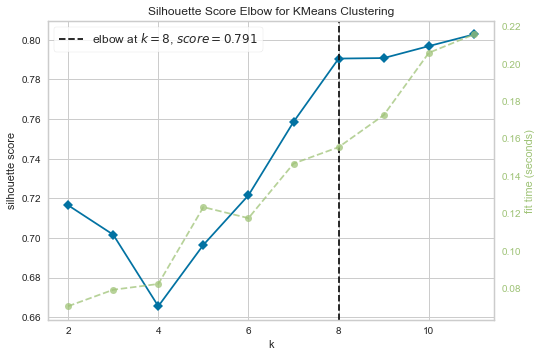

,Ef_Num_DT_DevOpsSpecialist,Ef_Num_DT_DSOrMLSpecialist,Ef_Num_DT_DeveloperFullStack,Ef_Num_DT_ProductMgr,Ef_Num_DT_EnggMgr,Ef_Num_DT_SeniorExecOrVP,Ef_Num_DT_DataOrBA,Ef_Num_DT_DataEr,Ef_Num_DT_ErSiteReliab,Ef_Num_DT_SysAdmin,...,Ef_Num_DT_DevBackend,Ef_Num_DT_DevFrontEnd,Ef_Num_DT_DevEmbedApps,Ef_Num_DT_DevGameOrGraphics,Ef_Num_DT_Designer,Ef_Num_DT_Scientist,Ef_Num_DT_DevMob,Ef_Num_DT_DevQATest,Ef_Num_DT_DevDeskOrEntApps,Ef_Num_DT_AcadResearch
Segment 0,209214.0,204606.0,208899.0,207278.0,208116.0,208052.0,208768.0,206339.0,207787.0,209196.0,...,208686.0,209166.0,206833.0,208643.0,208648.0,208321.0,208961.0,209910.0,209065.0,210697.0
Segment 1,209211.0,204586.0,209736.0,206946.0,208875.0,207976.0,210608.0,238506.0,211620.0,209247.0,...,212277.0,209201.0,209374.0,209200.0,209869.0,209131.0,208980.0,207948.0,209348.0,209681.0
Segment 2,209209.0,204642.0,207383.0,252931.0,214471.0,207920.0,210921.0,209892.0,210106.0,209277.0,...,211073.0,212058.0,209228.0,210038.0,213995.0,208870.0,210704.0,205746.0,209770.0,209174.0
Segment 3,209212.0,263205.0,212145.0,210839.0,209920.0,210041.0,212087.0,217616.0,209341.0,209225.0,...,207791.0,207374.0,210118.0,209329.0,209499.0,214289.0,208632.0,209626.0,208940.0,203884.0
Segment 4,209213.0,204676.0,209683.0,206780.0,209052.0,207699.0,208624.0,206218.0,207491.0,209222.0,...,211119.0,210476.0,234110.0,213309.0,211001.0,208459.0,211629.0,207433.0,210563.0,210807.0
Segment 5,209213.0,204514.0,210997.0,207253.0,206450.0,208409.0,208664.0,207520.0,209215.0,209220.0,...,206682.0,208658.0,209168.0,210736.0,209839.0,221091.0,208943.0,208251.0,209171.0,180362.0
Segment 6,209211.0,204510.0,207351.0,219127.0,223249.0,250317.0,209585.0,210659.0,209410.0,209277.0,...,211254.0,209490.0,210775.0,211359.0,210521.0,209581.0,211217.0,208677.0,209645.0,208501.0
Segment 7,209200.0,204599.0,208815.0,205824.0,215907.0,206180.0,208924.0,205997.0,232808.0,209317.0,...,212655.0,209521.0,206143.0,208999.0,209404.0,208114.0,208707.0,204713.0,209194.0,210248.0



 Saved clustering model cluster.pkl to the models folder... 


 Saved cleaned and clustered dataset us_community_df.csv to the data folder... 



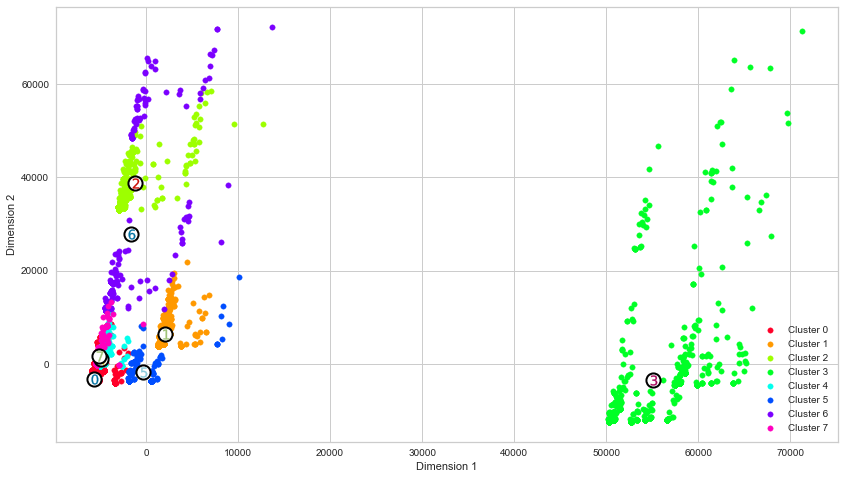

In [4]:
#Call the main function to generate and save the cluster model and save the data containing preducted clusters 
# to a .csv file
main('data/survey_results_public.csv','data/survey_results_schema.csv' \
     ,'models/cluster.pkl','data/us_community_df.csv')